In [1]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts')

import numpy as np
import pandas as pd
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import tifffile as tiff
from src.SMT_Analysis_BP.helpers.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.blob_detection import *
from src.SMT_Analysis_BP.Parameter_Store.global_params import PIXELSIZES
from skimage import io
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg') 
#import curve_fit 
from scipy.optimize import curve_fit

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_6635/1504517122.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
path = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/BEADS/0.1um_beads/Movie/Beads_0.1_PSF_Z_4.tif"
#load the .tif file
image = io.imread(path)
print(image.shape)
Z_step = 0.1 #microns

(41, 392, 392)


In [3]:
#do the detection 
detection_args = {"median":False,
                "threshold":4e-2, #2.3e-4 for LacI
                "min_sigma":1.1/np.sqrt(2),
                "max_sigma":4/np.sqrt(2),
                "num_sigma":10,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":7,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":5,
                "centeroid_range":5,
                "height_range":20}


In [4]:
#make a df to store results of the 2d gaussian fit
df_blob = pd.DataFrame(columns=['Z_slice','x','y','I','sigma_x','sigma_y','offset','x_stderr','y_stderr',"intensity_sum"])
#fit the blobs for each z slice
for i in range(image.shape[0]):
    frame = image[i,:,:]
    blob_detector = blob_detection(path=frame,**detection_args)
    blob_detector._update_fitting_parameters(kwargs=fitting_args)
    c = blob_detector.detection(type="bp")
    for j in c["Fit"]:
        I = j.params["height"].value
        x = j.params["centroid_x"].value
        x_stderr = j.params["centroid_x"].stderr
        y = j.params["centroid_y"].value
        y_stderr = j.params["centroid_y"].stderr
        sigma_x = j.params["sigma_x"].value
        sigma_y = j.params["sigma_y"].value
        offset = j.params["background"].value
        #calculate the intensity sum over the blob using the fitted parameters
        intensity_sum = 2*np.pi*I*sigma_x*sigma_y
        #concatenate the results to the df not append
        df_blob = pd.concat([df_blob,pd.DataFrame([[i,x,y,I,sigma_x,sigma_y,offset,x_stderr,y_stderr,intensity_sum]],columns=df_blob.columns)])
df_blob.reset_index(drop=True,inplace=True) #reset the index

/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:816: RuntimeWarning: divide by zero encountered in scalar divide
  par.correl[varn2] = (self.result.covar[ivar, jvar] /
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/lmfit/minimizer.py:816: RuntimeWarning: invalid value encountered in scalar divide
  par.correl[varn2] = (self.result.covar[ivar, jvar] /


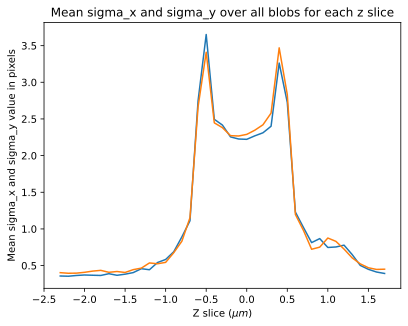

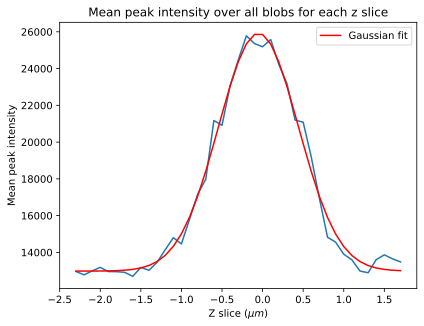

Fitted parameters: a = 12941.997765, x0 = -0.050815, sigma = 0.493015, c = 12981.653995


In [5]:
#for each z slice plot the mean of sigma_x and sigma_y
mean_sigma_x = []
mean_sigma_y = []
for i in range(image.shape[0]):
    mean_sigma_x.append(df_blob[df_blob["Z_slice"]==i]["sigma_x"].mean())
    mean_sigma_y.append(df_blob[df_blob["Z_slice"]==i]["sigma_y"].mean())
converted_z = np.arange(0,image.shape[0])
#center the z values at 23 = 0
converted_z = converted_z - 23
converted_z = converted_z*Z_step
plt.plot(converted_z,mean_sigma_x,label="sigma_x")
plt.plot(converted_z,mean_sigma_y,label="sigma_y")
plt.title("Mean sigma_x and sigma_y over all blobs for each z slice")
plt.xlabel("Z slice ($\mu m$)")
plt.ylabel("Mean sigma_x and sigma_y value in pixels")
plt.show()

#plot the peak intensity for each z slice
plt.plot(converted_z,df_blob.groupby("Z_slice").mean()["I"])
#fit a gaussian to the peak intensity
def gaussian(x, a, x0, sigma,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + c
x = converted_z
y = df_blob.groupby("Z_slice").mean()["I"]
popt,pcov = curve_fit(gaussian,x,y,p0=[1,0,1,1])
plt.plot(x,gaussian(x,*popt),"r-",label="Gaussian fit")
plt.legend()
plt.title("Mean peak intensity over all blobs for each z slice")
plt.xlabel("Z slice ($\mu m$)")
plt.ylabel("Mean peak intensity")
plt.show()
print("Fitted parameters: a = %f, x0 = %f, sigma = %f, c = %f" % (popt[0],popt[1],popt[2],popt[3]))



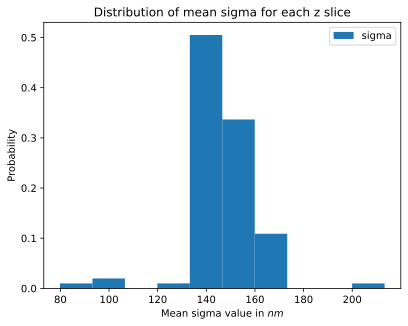

Mean sigma in microns:  146.62583081635304
Standard deviation of sigma in microns:  13.705873388864479
N =  101


In [6]:
#the z slice in the focus is 23
z_focus = 23
#plot the distribution of sigma_x and sigma_y for the z slice in focus
mean_sigma = []
for i in df_blob[df_blob["Z_slice"]==z_focus].index:
    mean_sigma.append(np.mean([df_blob.loc[i,"sigma_x"],df_blob.loc[i,"sigma_y"]]))
mean_sigma = np.array(mean_sigma)

from src.SMT_Analysis_BP.Parameter_Store.global_params import PIXELSIZES

plt.hist(mean_sigma*PIXELSIZES["olympus_pixel_size_1x1"],
         bins=int(np.sqrt(len(mean_sigma))),
         label="sigma",
         weights=np.ones(len(mean_sigma))/len(mean_sigma))
plt.title("Distribution of mean sigma for each z slice")
plt.xlabel("Mean sigma value in $n m$")
plt.ylabel("Probability")
plt.legend()
plt.show()
print("Mean sigma in microns: ",np.mean(mean_sigma*PIXELSIZES["olympus_pixel_size_1x1"]))
print("Standard deviation of sigma in microns: ",np.std(mean_sigma*PIXELSIZES["olympus_pixel_size_1x1"]))
print("N = ",len(mean_sigma))

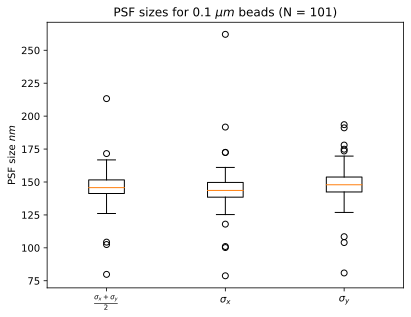

In [7]:
#plot the distribution as a box plot
#plot the sigma_x and sigma_y values for the z slice in focus as a box plot
plt.boxplot([mean_sigma*PIXELSIZES["olympus_pixel_size_1x1"],df_blob[df_blob["Z_slice"]==z_focus]["sigma_x"]*PIXELSIZES["olympus_pixel_size_1x1"],df_blob[df_blob["Z_slice"]==z_focus]["sigma_y"]*PIXELSIZES["olympus_pixel_size_1x1"]])
plt.title("PSF sizes for 0.1 $\mu m$ beads (N = {})".format(len(mean_sigma)))
plt.ylabel("PSF size $n m$")
plt.xticks([1,2,3],[r"$\frac{\sigma_{x}+\sigma_{y}}{2}$","$\sigma_{x}$","$\sigma_{y}$"])
plt.show()



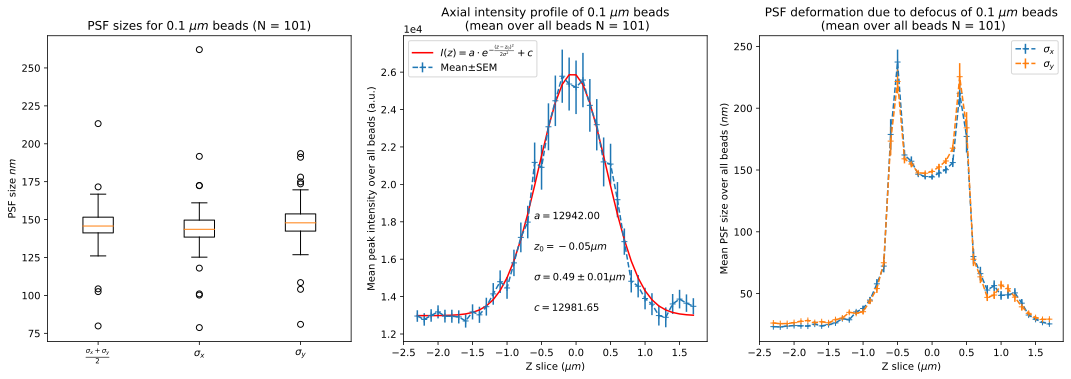

In [59]:
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[1,0])
ax1.boxplot([mean_sigma*PIXELSIZES["olympus_pixel_size_1x1"],df_blob[df_blob["Z_slice"]==z_focus]["sigma_x"]*PIXELSIZES["olympus_pixel_size_1x1"],df_blob[df_blob["Z_slice"]==z_focus]["sigma_y"]*PIXELSIZES["olympus_pixel_size_1x1"]])
ax1.set_title("PSF sizes for 0.1 $\mu m$ beads (N = {})".format(len(mean_sigma)))
ax1.set_ylabel("PSF size $n m$")
ax1.set_xticks([1,2,3],[r"$\frac{\sigma_{x}+\sigma_{y}}{2}$","$\sigma_{x}$","$\sigma_{y}$"])


x = converted_z
y = df_blob.groupby("Z_slice").mean()["I"]
y_err = df_blob.groupby("Z_slice").std()["I"]/np.sqrt(len(df_blob.groupby("Z_slice").mean()["I"]))

ax2 = fig.add_subplot(gs[1,1])
ax2.errorbar(converted_z,df_blob.groupby("Z_slice").mean()["I"],yerr=y_err,label="Mean"+ u"\u00B1"+ "SEM",marker="+",linestyle="--")
#fit a gaussian to the peak intensity
def gaussian(x, a, x0, sigma,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + c

popt,pcov = curve_fit(gaussian,x,y,p0=[1,0,1,1])
ax2.plot(x,gaussian(x,*popt),"r-",label=r"$I(z) = a\cdot e^{-\frac{(z-z_0)^2}{2\sigma^2}} + c$")
ax2.legend()
ax2.set_title("Axial intensity profile of 0.1 $\mu m$ beads\n (mean over all beads N = 101)")
ax2.set_xlabel("Z slice ($\mu m$)")
ax2.set_ylabel("Mean peak intensity over all beads (a.u.)")
#put the y ticks in scientific notation
ax2.ticklabel_format(axis="y",style="sci",scilimits=(0,0))

#write the fitted parameters on the plot using latex formatting
ax2.text(0.43,0.4,r"$a = {:.2f}$".format(popt[0]),transform=ax2.transAxes,fontsize=10)
ax2.text(0.43,0.3,r"$z_0 = {:.2f} \mu m$".format(popt[1]),transform=ax2.transAxes,fontsize=10)
#add the sigma with error   
ax2.text(0.43,0.2,r"$\sigma = {:.2f} \pm {:.2f} \mu m$".format(popt[2],np.sqrt(pcov[2,2])),transform=ax2.transAxes,fontsize=10)
ax2.text(0.43,0.1,r"$c = {:.2f}$".format(popt[3]),transform=ax2.transAxes,fontsize=10)

#for each z slice plot the mean of sigma_x and sigma_y
mean_sigma_x = []
mean_sigma_y = []
sem_sigma_x = []
sem_sigma_y = []
for i in range(image.shape[0]):
    mean_sigma_x.append(df_blob[df_blob["Z_slice"]==i]["sigma_x"].mean())
    mean_sigma_y.append(df_blob[df_blob["Z_slice"]==i]["sigma_y"].mean())
    sem_sigma_x.append(df_blob[df_blob["Z_slice"]==i]["sigma_x"].std()/np.sqrt(len(df_blob[df_blob["Z_slice"]==i]["sigma_x"])))
    sem_sigma_y.append(df_blob[df_blob["Z_slice"]==i]["sigma_y"].std()/np.sqrt(len(df_blob[df_blob["Z_slice"]==i]["sigma_y"])))

mean_sigma_x = np.array(mean_sigma_x)*PIXELSIZES["olympus_pixel_size_1x1"]
mean_sigma_y = np.array(mean_sigma_y)*PIXELSIZES["olympus_pixel_size_1x1"]
sem_sigma_x = np.array(sem_sigma_x)*PIXELSIZES["olympus_pixel_size_1x1"]
sem_sigma_y = np.array(sem_sigma_y)*PIXELSIZES["olympus_pixel_size_1x1"]

converted_z = np.arange(0,image.shape[0])
#center the z values at 23 = 0
converted_z = converted_z - 23
converted_z = converted_z*Z_step
ax3 = fig.add_subplot(gs[1,2])
ax3.errorbar(converted_z,mean_sigma_x,yerr=sem_sigma_x,label=r"$\sigma_x$",marker="+",linestyle="--")
ax3.errorbar(converted_z,mean_sigma_y,yerr=sem_sigma_y,label=r"$\sigma_y$",marker="+",linestyle="--")

ax3.set_title("PSF deformation due to defocus of 0.1 $\mu m$ beads\n (mean over all beads N = 101)")
ax3.set_xlabel("Z slice ($\mu m$)")
ax3.set_ylabel("Mean PSF size over all beads ($n m$)")

ax3.legend()


plt.tight_layout()

plt.show()
